In [1]:
import os
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from domid.arg_parser import mk_parser_main
os.chdir('../')
print("Current working directory:", os.getcwd())

Current working directory: /home/didsr/Documents/SDCN_December/DomId


# Some Helper functions that are going to be useful for the analysis of the experimental results

*  `get_most_recent_directory(directory)` takes a directory path as input, retrieves a list of directories within it, sorts them by their creation time in descending order, and returns the path of the most recently created directory. That is how we will obtain the repo with the results for the latest experiment.
* `load_files ` reads a CSV file named "clustering_results.csv" located at the specified path of the experimnet. It then extracts specific columns from the results DataFrame that are used to analyze results.
* `something_per_domain` takes two arrays as input: domain, representing predicted domain labels, and another_label, representing some other label corresponding to each predicted domain label. It calculates the counts of occurrences of combination of predicted domain and another labels (e.g how many red digits in domain 0).
*  `plot_something_per_domain_proportion` generates a bar graph illustrating the proportion of counts for each unique label within each predicted domain.

In [55]:

def get_most_recent_directory(directory):
    try:
        directories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
        directories.sort(key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=True)
        return os.path.join(directory, directories[0])
    except Exception as e:
        print("Error:", e)
        return None



In [43]:

def load_files(path):
    df = pd.read_csv(path+'clustering_results.csv')
    
    domain = df['predictions'].values
    
    vec_d = df['vec_d_labels'].values
    vec_y = df['vec_y_labels'].values
    img_locs = df['image_id_labels'].values

    Z = np.load(path + "Z_space.npy")
    model_name = path.split('_')[-1]

    #args = np.loadtxt(path + "arguments.txt", dtype=str, usecols=0)  # , delimiter = '\n')
    #img_locs = np.loadtxt(path + "img_id.txt", dtype=str)
    
    return domain, vec_d, vec_y, img_locs, model_name

In [48]:
def something_per_domain(domain, another_label):
    """
    domain - predicted domain labels 
    another_label - some other label that corresponds to each of the predicted domain (
    assumed that both domain and something have the same img_loc reference order 
    """
    u_something = np.unique(another_label)
    u_domain = np.unique(domain)
    print('unique predicted domain', u_domain)
    print('unique true label', u_something)
    
    array_counters=[]
    for i in u_domain:
        for j in u_something:
            counter = 0
            for idx in range(0, len(domain)):
                if domain[idx]==i and another_label[idx]==j:
                    counter+=1
            
            array_counters.append(counter)
    return array_counters
                    
        
    

In [51]:
def plot_something_per_domain_proportion(domain, another_label, counts, fs, legend = False, thres = None, title = None, digit_plot = True):
    """
    domain - predicted domain labels
    another_label - another label aassociated with each predicted domain (should be same shape as domain)
    counts - countes of each another label in each of the predicted domain (see something_per_domain function)
    fs - font size
    colors - colors of each segment on the bargraph
    legend - legend of unique another lables
    thres - if thresholding of another label is required then should be shpecifies (also see apply_threshold function)
    
    """
    u_domains = np.unique(domain)
    N = len(u_domains)
    
    u_another_label = np.unique(another_label)
    print('unique labels', u_another_label)
    print(u_domains)
    counts = np.array(counts)
    narray = np.array_split(counts, N)

    if thres:
        u_another_label_dic = apply_threshold(u_another_label, narray, thres, N)
        #print(u_another_label_dic.values())
        u_another_label = list(u_another_label_dic.keys())
        narray = list(u_another_label_dic.values())
        narray = np.transpose(narray)

   # print(narray)
    #print(len(u_domains), len(u_another_label))
    # c = ['blue', 'teal', 'pink', 'orange', 'green', 'red', 'plum', 'grey', 'purple', 'yellow']
    # c = ['lightblue', 'steelblue', 'royalblue', 'mediumpurple', 'darkmagenta','orchid', 'lightpink', 'lightcoral', 'maroon', 'sandybrown']
    
    if digit_plot:
        c =  ['darkseagreen', 'forestgreen', 'aquamarine', 'lightseagreen', 'teal', 'steelblue','lightblue', 'royalblue','navy', 'lightslategrey' ]

    else:
        c = ['mediumpurple', 'darkmagenta','orchid', 'lightpink', 'lightcoral', 'maroon', 'sandybrown', 'peachpuff', 'goldenrod', 'gold']
  
        
    plt.figure(figsize = (5, 5))
    for i in range(0, len(u_domains)):
        for jj in range(0,len(u_another_label)):
            
            if jj>0:
                bottom = np.sum(narray[i][:jj])/np.sum(narray[i])
            else:
                bottom = 0
            ##print(i, narray[i][jj])
            #print(c[jj])
            plt.bar(i, narray[i][jj]/np.sum(narray[i]), bottom = bottom, color = c[jj])
    x = np.linspace(0, N-1, N)
    x_ticks = [str(item)[0] for item in u_domains]
    #plt.ylabel("Proportion", fontsize=fs)
    plt.xticks(x, x_ticks, fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlabel("Domain", fontsize=fs)
    plt.title(title, fontsize = fs, weight = 'bold')
    plt.tick_params(left = False, labelleft = False)
    if legend:
        plt.legend(legend, bbox_to_anchor=(0.5, 10))
    else:
        plt.legend(u_another_label, bbox_to_anchor=(1, 1.1), fancybox=True, shadow=True, fontsize = fs)
    plt.show()

# VaDE with Colored MNIST 

In [54]:
parser = mk_parser_main()
args = parser.parse_args(
    ["--task",
        "mnistcolor10",
         "--te_d", "0",
        "--tr_d", "0","1","2","3", "4", "5", "6", "7", "8", "9", 
        "--zd_dim", "20",
        "--d_dim","10",
        "--dpath", "zout",
        "--model", "vade",
        "--apath", "domid/algos/builder_vade.py",
        "--bs", "2",
        "--split", "0.8",
        "--L", "5",
        "--debug", "--nocu",
        "--model_method", "cnn",
        "--prior", "Gaus",
        "--pre_tr","9",
        "--epos", "20",
         "--lr", "0.0005",
        "--trainer","cluster",
        "--feat_extract","vae"
    ]
)

In [59]:
from domid.trainers.zoo_trainer import TrainerChainNodeGetter
from domid.tasks.task_mnist_color import NodeTaskMNISTColor10

from domid.models.model_vade import mk_vade
from domid.models.model_dec import mk_dec

from domid.algos.observers.b_obvisitor_clustering_only import ObVisitorClusteringOnly
from domainlab.algos.observers.c_obvisitor_cleanup import ObVisitorCleanUp
from domainlab.algos.msels.c_msel_oracle import MSelOracleVisitor
from domainlab.algos.msels.c_msel_val import MSelValPerf
from domid.compos.exp.exp_main import Exp


In [60]:


device = 'cpu'
task = NodeTaskMNISTColor10()
trainer = TrainerChainNodeGetter(args.trainer)()
model = mk_vade()(zd_dim=args.zd_dim,
            d_dim=args.d_dim,
            device=args.device,
            L=args.L,
            i_c=task.isize.c,
            i_h=task.isize.h,
            i_w=task.isize.w,
            args=args,
        )
exp = Exp(args)
observer = ObVisitorCleanUp(ObVisitorClusteringOnly(exp, MSelOracleVisitor(MSelValPerf(max_es=args.es)), device))
trainer.init_business(model, task, observer, device, args)

The sets of training and test domains overlap -- be aware of data leakage or training to the test!


ConvolutionalEncoder(
  (encod): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (mu_layer): Linear(in_features=2048, out_features=20, bias=True)
  (log_sigma2_layer): Linear(in_features=2048, out_features=20, bias=True)
)
ConvolutionalDecoder(
  (linear): Linear(in_features=20, out_features=2048, bias=True)
  (sigmoid_layer): Sigmoid()
  (unflat): UnFlatten()
  (decod): S


using device: cpu

The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/home/didsr/Documents/SDCN_December/DomId/DomainLab/domainlab/tasks/a_task.py:168: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


ConvolutionalEncoder(
  (encod): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (mu_layer): Linear(in_features=2048, out_features=20, bias=True)
  (log_sigma2_layer): Linear(in_features=2048, out_features=20, bias=True)
)
ConvolutionalDecoder(
  (linear): Linear(in_features=20, out_features=2048, bias=True)
  (sigmoid_layer): Sigmoid()
  (unflat): UnFlatten()
  (decod): S




!!!: not committed yet
/home/didsr/Documents/SDCN_December/DomId/DomainLab/domainlab/utils/get_git_tag.py:16: UserWarning: !!!: not committed yet
  warnings.warn("!!!: not committed yet")



b'f10f04a'
The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/home/didsr/Documents/SDCN_December/DomId/DomainLab/domainlab/tasks/a_task.py:168: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(
model name: debug_mnistcolor10_te_rgb_31_119_180_vade_bf10f04a_not_commited_2024md_03md_04_12_57_59_seed_0
The sets of training and test domains overlap -- be aware of data leakage or training to the test!


############################################################
Pretraining initialized.
############################################################
______Created directory to save result_________
no split between train and test datasets
############################################################
Pretraining initialized.
############################################################
______Created directory to save result_________


In [27]:
for i in range(args.epos):
    trainer.tr_epoch(i)

Epoch 0. Pretraining.
pi:
[0.09909446 0.09689409 0.10723349 0.0984749  0.08032393 0.09149601
 0.15074684 0.09059513 0.11040035 0.07474077]
epoch: 0
pooled train clustering acc (vec_d correlation):  0.499375
[[377   0   5  74   1   0  17   1   0   8]
 [  0 246  17   0  27 189   0  14   4  10]
 [  6   8 341  33  88  38   6   8   1  57]
 [ 61   0  27 242  13   0  29   0   6  29]
 [  0  11  14   8  83  22  28  36  19  40]
 [  0  18  40   4  64 179   7   4  25  60]
 [ 36   0  25 103  55  10 308   4  98 199]
 [  0  25   8   5  84   8   5 306  11  12]
 [  0   0   1  11  37  10  80  10 312  62]
 [  0 172   2   0  28  24   0  97   4   3]]
clustering validation acc:  0.4975
[[94  0  3 22  0  0 11  0  0  0]
 [ 0 68  3  0 11 51  1  6  2  1]
 [ 2  1 85  9 23  9  4  3  0  9]
 [13  0  8 55  0  0  5  0  3 10]
 [ 0  4  1  3 23  5  7 13 10 10]
 [ 0  3 11  0 18 49  2  2  5 20]
 [11  0  3 28 13  0 70  0 20 49]
 [ 0  9  3  0 23  0  2 74  2  1]
 [ 0  0  0  3  5  2 18  0 78 19]
 [ 0 35  3  0  4  4  0 22  0  

pi:
[0.08645078 0.0948687  0.09620982 0.11573938 0.09104345 0.09748473
 0.08947327 0.1064973  0.13133122 0.09090144]
epoch: 6
pooled train clustering acc (vec_d correlation):  0.256875
[[ 50  31  49  32  44  29  49  16  20  46]
 [ 15  89  49  29   5  19  38  12  58  81]
 [ 51  21  67  25  76  57  50  44  12  34]
 [ 46  34  52 122  16  49  76 121  31  10]
 [ 76   9  25  16 168  67  14  40   4  27]
 [ 26  24  48  40  93 167  20  41   8  26]
 [ 38  41  59  23  30  33  42  17  24  94]
 [123  12  50  32  23  19  85 142  12   9]
 [ 20 141  30 146   2  17  67  33 273  40]
 [ 35  78  51  15  23  23  39  14  38 113]]
clustering validation acc:  0.2816666666666667
[[ 9 10 14  4 12  3  9  2  6 10]
 [ 8 24  5  5  2  4  7  2 14 19]
 [21  3 28  4 22 17 12 14  0 12]
 [13  7  4 40  5  8 21 31  8  2]
 [ 6  1 17  0 33 17  7  2  0  5]
 [19  7  7 11 25 40  5 10  2  5]
 [12 12 12  6  3 12 16  3  4 20]
 [16  2 26 13 12  6 22 46  3  3]
 [ 4 34  2 28  0  5 15 10 72 14]
 [12 20  5  9  6  8  6  0 11 30]]
pooled

pi:
[0.06948758 0.06394527 0.05389053 0.12550886 0.09758573 0.09744161
 0.10326182 0.11861858 0.14020903 0.13005109]
epoch: 12
pooled train clustering acc (vec_d correlation):  0.9116666666666666
[[480   0   0   0   0   0   0   0   0   0]
 [  0 202   0   0   0   0 134   0   0   0]
 [  0   0 473   0   0   0   0   0   0   0]
 [  0   0   4 480   0   0   0   0   0   0]
 [  0   0   0   0 480   0   0   0   0   0]
 [  0   0   3   0   0 480   0   0   0   0]
 [  0 278   0   0   0   0 341   0   0   0]
 [  0   0   0   0   0   0   0 480   0   0]
 [  0   0   0   0   0   0   5   0 480   0]
 [  0   0   0   0   0   0   0   0   0 480]]
clustering validation acc:  0.9166666666666666
[[120   0   0   0   0   0   0   0   0   0]
 [  0  49   0   0   0   0  27   0   0   0]
 [  0   0 119   0   0   0   0   0   0   0]
 [  0   0   1 120   0   0   0   0   0   0]
 [  0   0   0   0 120   0   0   0   0   0]
 [  0   0   0   0   0 120   0   0   0   0]
 [  0  71   0   0   0   0  92   0   0   0]
 [  0   0   0   0   0   0

pi:
[0.09882268 0.08887931 0.0965841  0.10055324 0.10092426 0.100375
 0.10874601 0.10145033 0.10199052 0.10167453]
epoch: 18
pooled train clustering acc (vec_d correlation):  0.9229166666666667
[[480   0   0   0   0   0   0   0   0   0]
 [  0 282   0   0   0   0 172   0   0   0]
 [  0   0 480   0   0   0   0   0   0   0]
 [  0   0   0 480   0   0   0   0   0   0]
 [  0   0   0   0 480   0   0   0   0   0]
 [  0   0   0   0   0 480   0   0   0   0]
 [  0 198   0   0   0   0 308   0   0   0]
 [  0   0   0   0   0   0   0 480   0   0]
 [  0   0   0   0   0   0   0   0 480   0]
 [  0   0   0   0   0   0   0   0   0 480]]
clustering validation acc:  0.9275
[[120   0   0   0   0   0   0   0   0   0]
 [  0  75   0   0   0   0  42   0   0   0]
 [  0   0 120   0   0   0   0   0   0   0]
 [  0   0   0 120   0   0   0   0   0   0]
 [  0   0   0   0 120   0   0   0   0   0]
 [  0   0   0   0   0 120   0   0   0   0]
 [  0  45   0   0   0   0  78   0   0   0]
 [  0   0   0   0   0   0   0 120   0  

In [64]:


directory = "./notebooks"
vade_results_path = get_most_recent_directory(directory)
print('Results from the following folder are going to be analyzed: ', vade_results_path)


domain, vec_d, vec_y, img_locs, model_name = load_files(vade_results_path+'/')
color = vec_d
digit = vec_y
model_name = vade_results_path.split('_')[-1]

Results from the following folder are going to be analyzed:  ./notebooks/2024-03-04 12:59:51.740260_mnistcolor10_dec


FileNotFoundError: [Errno 2] No such file or directory: './notebooks/2024-03-04 12:59:51.740260_mnistcolor10_dec/clustering_results.csv'

In [49]:
digits_per_domain = something_per_domain(domain, digit)

unique predicted domain [ 1  2  3  4  5  6  7  8  9 10]
unique true label [0 1 2 3 4 5 6 7 8 9]


In [50]:
colors_per_domain = something_per_domain(domain, color)

unique predicted domain [ 1  2  3  4  5  6  7  8  9 10]
unique true label [0 1 2 3 4 5 6 7 8 9]


unique labels [0 1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


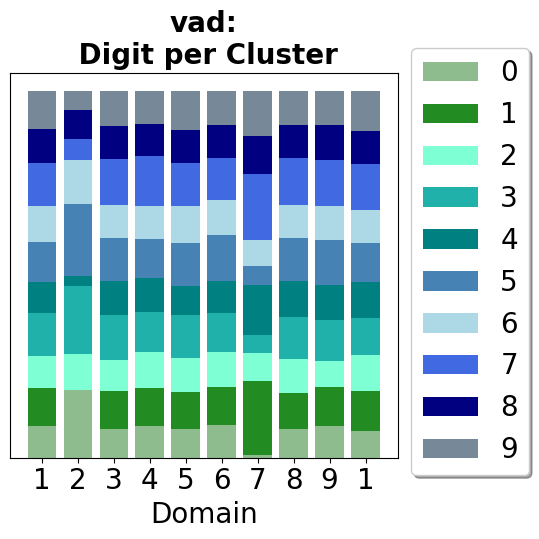

In [52]:
plot_something_per_domain_proportion(domain, digit, digits_per_domain, fs =20,title = model_name+':\n Digit per Cluster')

unique labels [0 1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


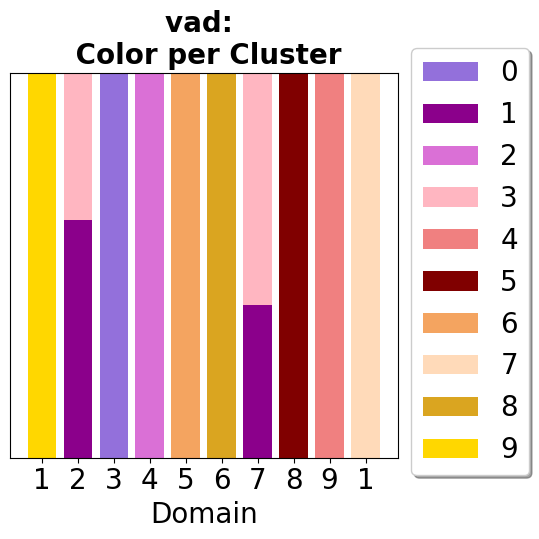

In [53]:
plot_something_per_domain_proportion(domain, color, colors_per_domain, fs =20, title = model_name+': \n Color per Cluster', digit_plot = False ) 

# DEC with Colored MNIST 

In [65]:
parser = mk_parser_main()
args = parser.parse_args(
    ["--task",
        "mnistcolor10",
         "--te_d", "0",
        "--tr_d", "0","1","2","3", "4", "5", "6", "7", "8", "9", 
        "--zd_dim", "20",
        "--d_dim","10",
        "--dpath", "zout",
        "--model", "dec",
        "--apath", "domid/algos/builder_dec.py",
        "--bs", "2",
        "--split", "0.8",
        "--L", "5",
        "--debug", "--nocu",
        "--model_method", "cnn",
        "--prior", "Gaus",
        "--pre_tr","9",
        "--epos", "20",
         "--lr", "0.0005",
        "--trainer","cluster",
        "--feat_extract","vae"
    ]
)

In [66]:


device = 'cpu'
task = NodeTaskMNISTColor10()
trainer = TrainerChainNodeGetter(args.trainer)()
model = mk_dec()(zd_dim=args.zd_dim,
            d_dim=args.d_dim,
            device=args.device,
            L=args.L,
            i_c=task.isize.c,
            i_h=task.isize.h,
            i_w=task.isize.w,
            args=args,
        )
exp = Exp(args)
observer = ObVisitorCleanUp(ObVisitorClusteringOnly(exp, MSelOracleVisitor(MSelValPerf(max_es=args.es)), device))
trainer.init_business(model, task, observer, device, args)

The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/home/didsr/Documents/SDCN_December/DomId/DomainLab/domainlab/tasks/a_task.py:168: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


no split between train and test datasets



using device: cpu

The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/home/didsr/Documents/SDCN_December/DomId/DomainLab/domainlab/tasks/a_task.py:168: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


no split between train and test datasets





!!!: not committed yet
/home/didsr/Documents/SDCN_December/DomId/DomainLab/domainlab/utils/get_git_tag.py:16: UserWarning: !!!: not committed yet
  warnings.warn("!!!: not committed yet")



b'f10f04a'
The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/home/didsr/Documents/SDCN_December/DomId/DomainLab/domainlab/tasks/a_task.py:168: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(
model name: debug_mnistcolor10_te_rgb_31_119_180_dec_bf10f04a_not_commited_2024md_03md_04_13_12_02_seed_0
The sets of training and test domains overlap -- be aware of data leakage or training to the test!


############################################################
Pretraining initialized.
############################################################
______Created directory to save result_________
no split between train and test datasets
############################################################
Pretraining initialized.
############################################################
______Created directory to save result_________


In [67]:
for i in range(args.epos):
    trainer.tr_epoch(i)

Epoch 0. Pretraining.


NameError: name 'z' is not defined

In [ ]:


directory = "./notebooks"
vade_results_path = get_most_recent_directory(directory)
print('Results from the following folder are going to be analyzed: ', vade_results_path)


domain, vec_d, vec_y, img_locs, model_name = load_files(vade_results_path+'/')
color = vec_d
digit = vec_y
model_name = vade_results_path.split('_')[-1]

In [ ]:
digits_per_domain = something_per_domain(domain, digit)
colors_per_domain = something_per_domain(domain, color)
plot_something_per_domain_proportion(domain, digit, digits_per_domain, fs =20,title = model_name+':\n Digit per Cluster')
plot_something_per_domain_proportion(domain, color, colors_per_domain, fs =20, title = model_name+': \n Color per Cluster', digit_plot = False ) 

# CDVaDE for Colored MNIST 

In [84]:
parser = mk_parser_main()
args = parser.parse_args(
    ["--task",
        "mnistcolor10",
         "--te_d", "0",
        "--tr_d", "0","1","2","3", "4", "5", "6", "7", "8", "9", 
        "--zd_dim", "20",
        "--d_dim","10",
        "--dpath", "zout",
        "--model", "vade",
        "--apath", "domid/algos/builder_vade.py",
        "--bs", "2",
        "--split", "0.8",
        "--L", "5",
        "--debug", "--nocu",
        "--model_method", "cnn",
        "--prior", "Gaus",
        "--pre_tr","10",
        "--epos", "25",
         "--lr", "0.0005",
        "--trainer","cluster",
        "--feat_extract","vae",
         "--inject_var", "color",
         "--dim_inject", "10"
    ]
)

In [85]:


trainer = TrainerChainNodeGetter(args.trainer)()
model = mk_vade()(zd_dim=args.zd_dim,
            d_dim=args.d_dim,
            device=args.device,
            L=args.L,
            i_c=task.isize.c,
            i_h=task.isize.h,
            i_w=task.isize.w,
            args=args,
        )
print(model)
exp = Exp(args)
observer = ObVisitorCleanUp(ObVisitorClusteringOnly(exp, MSelOracleVisitor(MSelValPerf(max_es=args.es)), device))
trainer.init_business(model, task, observer, device, args)

The sets of training and test domains overlap -- be aware of data leakage or training to the test!


ConvolutionalEncoder(
  (encod): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (mu_layer): Linear(in_features=2048, out_features=20, bias=True)
  (log_sigma2_layer): Linear(in_features=2048, out_features=20, bias=True)
)
ConvolutionalDecoder(
  (linear): Linear(in_features=30, out_features=2048, bias=True)
  (sigmoid_layer): Sigmoid()
  (unflat): UnFlatten()
  (decod): S

/home/didsr/Documents/SDCN_December/DomId/DomainLab/domainlab/tasks/a_task.py:168: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


no split between train and test datasets



using device: cpu

The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/home/didsr/Documents/SDCN_December/DomId/DomainLab/domainlab/tasks/a_task.py:168: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


ConvolutionalEncoder(
  (encod): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (mu_layer): Linear(in_features=2048, out_features=20, bias=True)
  (log_sigma2_layer): Linear(in_features=2048, out_features=20, bias=True)
)
ConvolutionalDecoder(
  (linear): Linear(in_features=30, out_features=2048, bias=True)
  (sigmoid_layer): Sigmoid()
  (unflat): UnFlatten()
  (decod): S




!!!: not committed yet
/home/didsr/Documents/SDCN_December/DomId/DomainLab/domainlab/utils/get_git_tag.py:16: UserWarning: !!!: not committed yet
  warnings.warn("!!!: not committed yet")



b'f10f04a'
The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/home/didsr/Documents/SDCN_December/DomId/DomainLab/domainlab/tasks/a_task.py:168: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(
model name: debug_mnistcolor10_te_rgb_31_119_180_vade_bf10f04a_not_commited_2024md_03md_04_13_54_21_seed_0
The sets of training and test domains overlap -- be aware of data leakage or training to the test!


############################################################
Pretraining initialized.
############################################################
______Created directory to save result_________
no split between train and test datasets
############################################################
Pretraining initialized.
############################################################
______Created directory to save result_________


In [86]:
for i in range(args.epos):
    trainer.tr_epoch(i)

Epoch 0. Pretraining.
pi:
[0.10520849 0.08164732 0.11457517 0.08419103 0.0936702  0.09544729
 0.11942702 0.0984727  0.10279874 0.10456205]
epoch: 0
pooled train clustering acc (vec_d correlation):  0.17791666666666667
[[131  33  45  78   7  36 124  57  18  41]
 [ 24  61  20  40  35  25  21  29  45  27]
 [ 78  22 114  73  12  56  64  61  20  50]
 [ 17  35  30  32  46  41  29  23  34  34]
 [ 11  44  35  18  99  60  12  37  73  41]
 [ 36  27  58  25  37  81  39  37  21  41]
 [120  51  61  93  17  58 116  84  37  46]
 [ 19  54  45  34  74  46  27  55  62  66]
 [  7  70  22  27 100  45  13  49  77  46]
 [ 37  83  50  60  53  32  35  48  93  88]]
clustering validation acc:  0.19083333333333333
[[37 12 23 13  9  8 32 16  2  3]
 [ 6 21  5  6  9  2  9 13  6 20]
 [18  5 20 17 16 15 15 16  4  5]
 [ 6 10  6 15  5 11 10  6 10  5]
 [ 3 10  5  6 17 12  3  8 25 16]
 [ 6  5 12 18  7 23  8  8  7  5]
 [22 12 19 10 15 14 30 20  5  5]
 [ 9 11 16 12 13 14  7 12 22 16]
 [ 3 15  2  8 15 13  1  6 29 20]
 [10 1

pi:
[0.1143846  0.10021726 0.08860356 0.09568053 0.09372274 0.11138743
 0.08815924 0.11473911 0.09548816 0.09761738]
epoch: 7
pooled train clustering acc (vec_d correlation):  0.12979166666666667
[[73 54 58 55 58 36 51 49 51 36]
 [56 62 51 63 52 53 37 45 51 44]
 [42 26 45 54 56 31 31 45 37 38]
 [53 28 50 68 44 43 36 53 37 36]
 [48 39 41 40 55 40 42 42 34 47]
 [36 46 50 31 43 74 74 46 54 74]
 [38 41 44 44 38 39 54 44 39 36]
 [70 54 64 67 63 51 55 69 67 56]
 [32 72 36 26 25 62 54 46 64 54]
 [32 58 41 32 46 51 46 41 46 59]]
clustering validation acc:  0.15416666666666667
[[20 11 13 19 12 11 14 13 18  8]
 [13 17 14 11 13  3  7 13 11  8]
 [10 14 14 14 14  6  7 11  9  3]
 [17 13  6 17 16 11  9 14  7 14]
 [ 8 11 13  9 17 15 13  9  7 16]
 [20  4 12 12  9 28 17 12 21 15]
 [ 6 12  9  9 12  7 18 13  8  7]
 [14 17 16 12  9 17 11 17 14 19]
 [ 6 11 18  7  8 13 15  8 19 12]
 [ 6 10  5 10 10  9  9 10  6 18]]
pooled train clustering acc (vec_y correlation):  0.1175
[[21 10 13 16 17 20 14 16  6  6]
 [11

pi:
[0.12276398 0.03734416 0.04576982 0.24989893 0.03343896 0.23797596
 0.04251578 0.02682133 0.15276724 0.05070395]
epoch: 13
pooled train clustering acc (vec_d correlation):  0.16875
[[ 64  23  68  41   7  14  61  22  19  60]
 [  0  17   2   1   4   5   0  15   6   1]
 [ 12  10  36   3   0   1  21  14   6  29]
 [218 114 171 258 138 133 197 104 121 190]
 [  2   6  12   1   2   3   4  11   6  10]
 [115 153  89 125 178 194 101 139 159 104]
 [ 11   3  47  10   3   1  37   5   4  39]
 [  0  29  12   0   1   4   3  31   5   7]
 [ 48 119  21  36 145 123  42 131 151  20]
 [ 10   6  22   5   2   2  14   8   3  20]]
clustering validation acc:  0.16916666666666666
[[20  8 19 14  3  3 13  4  4  8]
 [ 0  7  0  1  1  1  1  4  2  1]
 [ 7  1  7  3  0  1  7  2  2  0]
 [53 23 43 57 43 31 49 28 40 55]
 [ 2  3  1  0  2  0  4  2  1  0]
 [17 36 31 38 44 45 15 37 36 35]
 [ 8  1 10  0  0  1 18  1  0  6]
 [ 2  9  1  0  0  1  6  8  0  0]
 [ 7 32  5  7 27 36  2 33 34 10]
 [ 4  0  3  0  0  1  5  1  1  5]]
poole

pi:
[0.0987131  0.08116291 0.09110324 0.15833643 0.06854704 0.14249453
 0.08573598 0.07425103 0.11101773 0.088638  ]
epoch: 19
pooled train clustering acc (vec_d correlation):  0.1475
[[ 85  12  63  75  69  25  74  19  31  17]
 [ 46  61  57  36  51  49  38  61  49  55]
 [ 64  65  66  51  62  52  62  54  52  56]
 [110  20  97 118  93  33 114  19  37  31]
 [ 19  30  28  26  34  20  25  32  15  23]
 [ 51  71  42  67  43 107  50  80 100  83]
 [ 43  41  40  47  46  37  47  50  40  50]
 [ 14  42  38  17  40  19  19  45  17  21]
 [  5  87   1   6   3 100   6  74  95  94]
 [ 43  51  48  37  39  38  45  46  44  50]]
clustering validation acc:  0.155
[[20  5 17 17 16  9 12  9  5  6]
 [10 14  8  9 11 14  8 14 13 13]
 [19  7 16 15 12 18 12 14 11 17]
 [29 16 30 32 28  4 32  6  8  9]
 [ 6  8  5  8  9  4  9  5  6  3]
 [16 21  9  9 17 25 18 20 18 15]
 [10  7 13 12 13 12 15 12  7 16]
 [ 0  4 11  9  2  5  5 11 11  5]
 [ 3 25  0  0  1 20  1 19 30 22]
 [ 7 13 11  9 11  9  8 10 11 14]]
pooled train cluster

Results from the following folder are going to be analyzed: 
 ./notebooks/2024-03-04 13:54:28.735036_mnistcolor10_vade
unique predicted domain [ 1  2  3  4  5  6  7  8  9 10]
unique true label [0 1 2 3 4 5 6 7 8 9]
unique predicted domain [ 1  2  3  4  5  6  7  8  9 10]
unique true label [0 1 2 3 4 5 6 7 8 9]
unique labels [0 1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


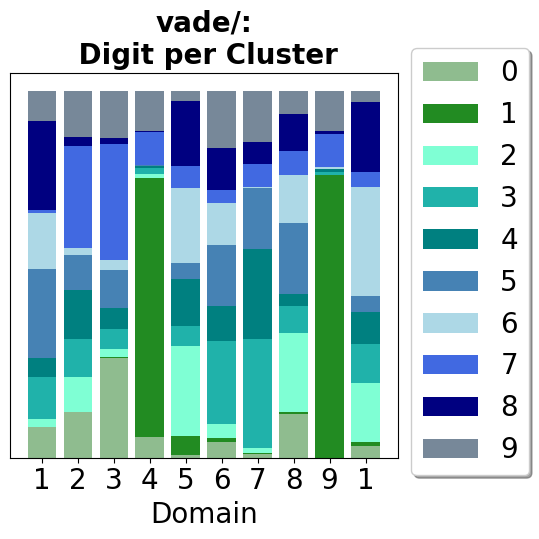

unique labels [0 1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


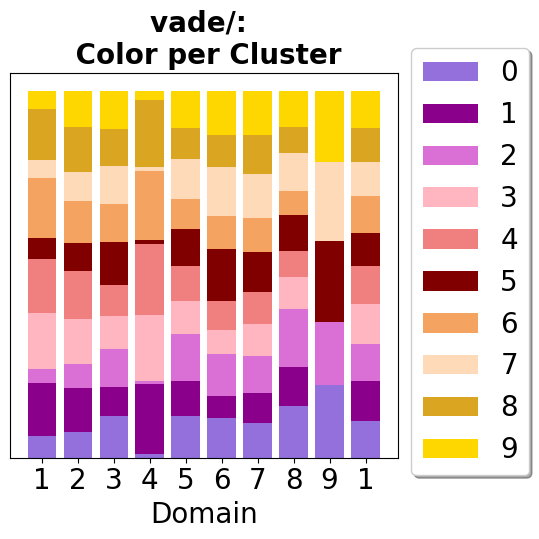

In [87]:


directory = "./notebooks"
cdvade_results_path = get_most_recent_directory(directory)
print('Results from the following folder are going to be analyzed: \n', cdvade_results_path)


domain, vec_d, vec_y, img_locs, model_name = load_files(cdvade_results_path+'/')
color = vec_d
digit = vec_y

digits_per_domain = something_per_domain(domain, digit)
colors_per_domain = something_per_domain(domain, color)
plot_something_per_domain_proportion(domain, digit, digits_per_domain, fs =20,title = model_name+':\n Digit per Cluster')
plot_something_per_domain_proportion(domain, color, colors_per_domain, fs =20, title = model_name+': \n Color per Cluster', digit_plot = False ) 